# Homework 4

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: The Information Content of the Yield Curve

## 1.1
**The Term Spread**

**1. What is the term spread?**
A: Term spread is a preditctor that is the difference between interest rates on short- and long-dated government securities. 

**2. What is the preferred measure of the term spread in the case?**
A: In the case, it is calculated as the 10 year treasury rate less three month treasury rate.


**3. What evidence is cited for the term spread's power in predicting recessions?**
A: The slope of the yield curve predicts subsequent US real GDP with a lead time of about four to six quarters. There is a positive relationship in which economic growth should be strong over the next four to six quarter with a positively sloped yield curve.

**4.Which is more important, the level of the term spread, its month-over-month change, or the level of short rates?**
TBA


**5. Using the file yields_2022-11-30.xlsx, calculate the term spread as of the end of November 2022. (Measure it with the 10-year and 1-year yields.)**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
filepath_rawdata = f'../data/yields_2022-11-30.xlsx'
rawdata = pd.read_excel(filepath_rawdata)
rawdata=rawdata.set_index(rawdata.columns[0])

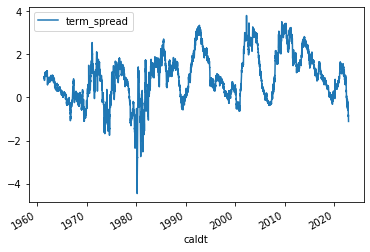

In [12]:
rawdata['term_spread']=rawdata[10]-rawdata[1]
rawdata[['term_spread']].plot()

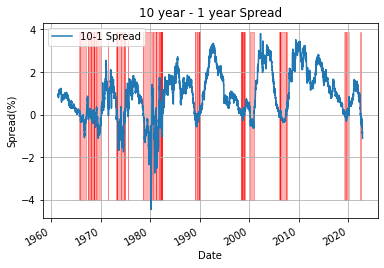

In [13]:
term_spread = (rawdata[10] - rawdata[1]).to_frame("10-1 Spread")
term_spread["ind"] = 0
term_spread.loc[term_spread["10-1 Spread"] < 0, "ind"] = 1
term_spread["ind_diff"] = term_spread["ind"].diff()
recession_date = term_spread[term_spread["ind_diff"] != 0].index[1:]
term_spread[["10-1 Spread"]].plot()
plt.title("10 year - 1 year Spread")
for i in range(0, len(recession_date)-1, 2):
    plt.fill_betweenx(np.arange(-4, 4, 0.1), np.repeat(recession_date[i], 80), np.repeat(recession_date[i+1], 80), color="red", alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Spread(%)")
plt.grid(True)

**What does this term spread suggest about economic growth, according to the evidence of Estrella?**
**TBA** 

We can see that the recent downward trend of the spread, where short-term interest rates are higher than long-term rates, typically indicates that the market is expecting economic growth to slow down or even a possible recession in the future. This is because a downward sloping yield curve is often seen as a sign of an impending recession, as investors demand a higher return for short-term bonds due to the perceived increased risk of holding them.


## 1.2 Term premia

**1. What is the term premium? Why is it impossible to get a direct measure of it?**
Term premium is the excess yield that investors require to commit to holding a long-term bond instead of a series of shorter-term bonds. It is impossible to get a direct measure of it because it is not observable. It is only possible to get an estimate. 

**2. Explain equations (1) and (2). Why does Sacks think this concept of the term spread complicates the relationship found by Estrella?**

Equation (1) explains the relationship between 10 year rate at time t and the expected average of the next 10 one-year rates. There's a difference of a term premium between them. Equation (2) explains the relationship between the slope of the yield curve and the average of expected changes in the short rate, which also has a term premium between as the difference. 

This concept complicate the relationship found by Estrella because tightening the term premium which woule lead to a falttened yield curve might not necessarily means that the growth should be slow as Estrella suggested. It might be the opposite




## 1.3

**Suppose the term premium is zero.**

**1. What does an upward sloping yield curve predict about future short-term rates?**

A: An upward sloping yield curve, where long-term interest rates are higher than short-term rates, typically indicates that the market expects future short-term rates to increase.

**In this case, is it risky to hold long-term bonds? Is this risk compensated?**

*TBA*

A: The case stated that the investors did not need to be compensated as much for holding long-dated fixed-rate assets because of the Fed's conduct and policy.

**Suppose the term premium increases 3 percentage points.What would change about your previous answer?**

A: An increase in the term premium, which is the extra return investors demand for holding a long-term bond instead of a series of shorter-term bonds, would increase the risk of holding long-term bonds. This is because as interest rates rise, the value of existing bonds decrease and long-term bonds are more sensitive to interest rate changes than short-term bonds. 

# 2 Calculating Forwards

Use the treasury issues in `'../data/selected_treasury_rates.xlsx.xlsx`. 

The selected treasuries are at nearly six-month intervals. Approximate that they mature at perfect 6-month intervals. (We are looking at them from the perspective of March 31, 2022.)

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
yield_file = '../data/yields_2022-11-30.xlsx'
yield_data = pd.read_excel(yield_file, index_col=0)
t_file = '../data/selected_treasury_rates.xlsx'
t_data =  pd.read_excel(t_file, index_col=0)

## 2.1 
Bootstrap the discount factor. Plot the answer in terms of discount factors and discount rates.

## 2.2
Calculate the entire forward curve for rates from $T$ to $T+0.5$, ranging $T$ from 0.5 through 6.5.

Plot the forward discount curve.



In [3]:
def calc_cashflows_HW4(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
        if quote_data.loc[i,'TMATDT'].day == 31:
            quote_data.loc[i,'TMATDT'] = quote_data.loc[i,'TMATDT'] - pd.DateOffset(1)

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

In [5]:
t_data['CALDT'] = pd.Timestamp('2022-03-31')
t_data.rename(columns={'maturity date':'TMATDT', 'coupon rate':'TCOUPRT'}, inplace=True)


In [6]:
CF = calc_cashflows_HW4(t_data)

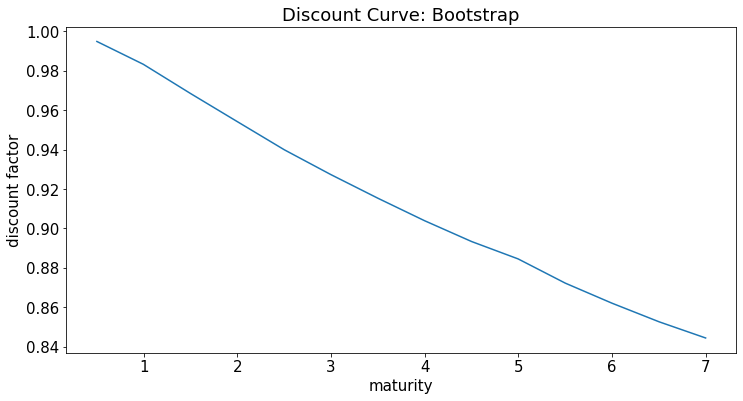

In [7]:
MODEL = bootstrap
DELTA = .5
MULT = 1


RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

t_current = t_data['CALDT'].iloc[0]
prices = t_data['price']
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

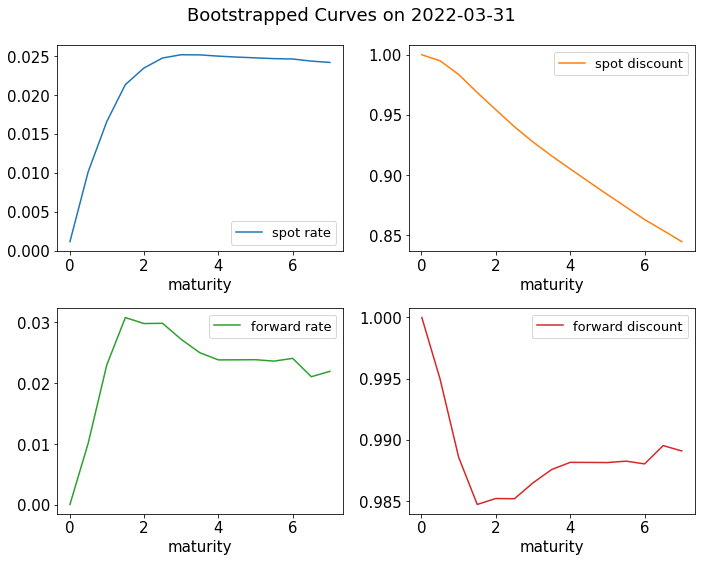

In [8]:
DATES = ['2022-03-31']

curveOLS = extract_spot_curves('2022-03-31', model=bootstrap, delta_maturity=DELTA, T=7, calc_forward=True,delta_forward_multiple=MULT, filter_maturity_dates=True)
fig, ax = plt.subplots(2,2,tight_layout=True,figsize=(10,8))
curveOLS.plot(subplots=True,ax=ax,title=f'Bootstrapped Curves on 2022-03-31')
plt.show()

## 2.3
Use the discount factors to calculate the forward rate from $T_1=2$ to $T_2=2.5$.

Do the same for $T_1=5$ to $T_2=5.5$.


In [ ]:
sd=curveOLS[['spot discount']]

In [34]:
F_T2_T25 = sd.loc[2.5]/sd.loc[2]
f_T2_T25 = -np.log(F_T2_T25)/0.5
print('the forward rate from T_1=2 to T_2=2.5: ',f_T2_T25[0])

the forward rate from T_1=2 to T_2=2.5:  0.029860885448130352


In [35]:
F_T5_T55 = sd.loc[5.5]/sd.loc[5]
f_T5_T55 = -np.log(F_T5_T55)/0.5
print('the forward rate from T_1=5 to T_2=5.5: ',f_T5_T55[0])

the forward rate from T_1=5 to T_2=5.5:  0.023634887382607828


In [36]:
curveOLS[['forward rate']].loc[2.5]

2022-03-31
forward rate    0.029861
Name: 2.5, dtype: float64

In [37]:
curveOLS[['forward rate']].loc[5.5]

2022-03-31
forward rate    0.023635
Name: 5.5, dtype: float64

What we calculated is the same as the forward rate graph above.


## 2.4
Explain how an FRA between $T_1$ and $T_2$ would function. How is the rate calculated above involved?

In [42]:
curveOLS[['spot rate']].loc[[2,5]]

2022-03-31,spot rate
maturity,
2.0,0.023440
5.0,0.024742


the party entering the FRA pays the spot rate, $r(T_1,T_2)$, on the notional.
The net receipt for the investor is, using a compounding frequency, $n$,
$\begin{align}
& \quad N \Delta\left[f_n(0,T_1,T_2)-r_n(T_1,T_2)\right]\\[6pt]
\Delta \equiv & \quad T_2-T_1\\[6pt]
N \equiv & \quad \text{Notional Investment}
\end{align}$

The forward rate (from T1 to T2) the party receives is set at time zero, while the spot rate at T1 the party pays is unknown until T1. 

For $T_1$=2 and $T_2$=2.5, the contract is set on time 0, the party pays spot rate of 0.023440 at T1=2, and receives forward rate f(0,T_1=2,T_2=2.5) = 0.029861.

For $T_1$=5 and $T_2$=5.5, the contract is set on time 0, the party pays spot rate of 0.024742 at T1=5, and receives forward rate f(0,T_1=5,T_2=5.5) = 0.023635.